# MadMiner particle physics tutorial

# Part 3c: Training a likelihood estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3c of this tutorial we will train a third neural estimator: this time of the likelihood function itself (rather than its ratio). We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import LikelihoodEstimator


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
# sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

14:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
14:25 madminer.analysis    INFO    Found 2 parameters
14:25 madminer.analysis    INFO    Did not find nuisance parameters
14:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:25 madminer.analysis    INFO    Found 3 observables
14:25 madminer.analysis    INFO    Found 15030 events
14:25 madminer.analysis    INFO      10041 generated from sm
14:25 madminer.analysis    INFO      1023 generated from w
14:25 madminer.analysis    INFO      1127 generated from neg_w
14:25 madminer.analysis    INFO      1450 generated from ww
14:25 madminer.analysis    INFO      1389 generated from neg_ww
14:25 madminer.analysis    INFO    Found morphing setup with 6 components
14:25 madminer.analysis    INFO    Did not find nuisance morphing setup


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood estimator with the SCANDAL method, so we focus on the `extract_samples_train_density()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [10]:
sampler.sample_train_density?

In [11]:
x, theta, t_xz, _ = sampler.sample_train_density(
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 15.), ('gaussian', 0., 15.)]),
    n_samples=100000,
    folder='./data/samples',
    filename='train_density',
    sample_only_from_closest_benchmark=True,
)

14:28 madminer.sampling    INFO    Extracting training sample for non-local score-based methods. Sampling and score evaluation according to ('random_morphing_points', (1000, [('gaussian', 0.0, 15.0), ('gaussian', 0.0, 15.0)]))
14:28 madminer.sampling    INFO    Starting sampling serially
14:28 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [ 10.46578532 -13.48456144]: (0.007204 +/- 0.000782) pb (10.856935261838029 %). Skipping these warnings in the future...
14:28 madminer.sampling    INFO    Sampling from parameter point 50 / 1000
14:28 madminer.sampling    INFO    Sampling from parameter point 100 / 1000
14:28 madminer.sampling    INFO    Sampling from parameter point 150 / 1000
14:28 madminer.sampling    INFO    Sampling from parameter point 200 / 1000
14:28 madminer.sampling    INFO    Sampling from parameter point 250 / 1000
14:28 madminer.sampling    INFO    Sampling from parameter point 300 / 1000
14:28 madminer.s

For the evaluation we'll need a test sample:

In [12]:
_ = sampler.sample_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='./data/samples',
    filename='test'
)

14:28 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to sm
14:28 madminer.sampling    INFO    Starting sampling serially
14:28 madminer.sampling    INFO    Sampling from parameter point 1 / 1
14:28 madminer.sampling    INFO    Effective number of samples: mean 19.046228721636165, with individual thetas ranging from 19.046228721636165 to 19.046228721636165


## 2. Train likelihood estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [13]:
LikelihoodEstimator?

In [3]:
estimator = LikelihoodEstimator(
    n_mades=3,
    n_hidden=(100,),
    activation="tanh"
)

To train this model we will minimize the SCANDAL loss function described in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [4]:
estimator.train(
    method='scandal',
    theta='data/samples/theta_train_density.npy',
    x='data/samples/x_train_density.npy',
    t_xz='data/samples/t_xz_train_density.npy',
    alpha=1.,
    n_epochs=20,
)

estimator.save('models/scandal')

14:29 madminer.ml          INFO    Starting training
14:29 madminer.ml          INFO      Method:                 scandal
14:29 madminer.ml          INFO      alpha:                  1.0
14:29 madminer.ml          INFO      Batch size:             200
14:29 madminer.ml          INFO      Optimizer:              amsgrad
14:29 madminer.ml          INFO      Epochs:                 20
14:29 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:29 madminer.ml          INFO      Validation split:       0.25
14:29 madminer.ml          INFO      Early stopping:         True
14:29 madminer.ml          INFO      Scale inputs:           True
14:29 madminer.ml          INFO      Shuffle labels          False
14:29 madminer.ml          INFO      Samples:                all
14:29 madminer.ml          INFO    Loading training data
14:29 madminer.ml          INFO    Found 100000 samples with 2 parameters and 3 observables
14:29 madminer.ml          INFO    Resc

## 3. Evaluate likelihood estimator

`estimator.evaluate_log_likelihood(theta,x)` estimated the log likelihood for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood, indexed by `[i_theta,i_x]`.

In [8]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)


In [9]:
estimator.load('models/scandal')

log_p_hat, _ = estimator.evaluate_log_likelihood(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

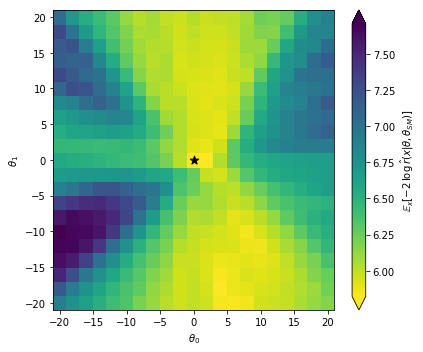

In [10]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_p_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!